### **Web 기반 코드 에이전트 실습**

In [ ]:
from dotenv import load_dotenv
load_dotenv()

### **그래프 State 설정**

In [1]:
from typing import TypedDict, Literal
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI

class AgentState(TypedDict):
    """The state of our agent."""
    question: str
    certainty_score: int 
    search_results: list 
    web_score: str  
    repo_name: str  
    generation: str

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

### **사용자의 질문에 대한 LLM의 답변 신뢰도 점검**

In [2]:
def check_certainty(state: AgentState) -> AgentState:
    """Evaluate certainty score for the query."""
    question = state["question"]
    class CertaintyScoreResponse(BaseModel):
        score: int = Field(description="Certainty score from 1 to 100. Higher is better.")
        
    certainty_scorer = llm.with_structured_output(CertaintyScoreResponse)

    print("---CHECKING LLM'S CERTAINTY")
    score_response = certainty_scorer.invoke(question)
    
    return {
        "certainty_score": score_response.score
    }


def route_based_on_certainty(state: AgentState) -> Literal["web_search", "direct_response"]:
    """Route to appropriate node based on certainty score."""
    score = state["certainty_score"]
    
    if score != 100:
        print("---LLM IS NOT CERTAIN SO IT WILL DO WEB SEARCH")
        return "web_search"
    else:
        print("---LLM IS CERTAIN SO IT WILL GENERATE ANSWER DIRECTLY")
        return "direct_response"

In [3]:
question = "Langgraph로 rag를 구축하는 방법"
class CertaintyScoreResponse(BaseModel):
    score: int = Field(description="Certainty score from 1 to 100. Higher is better.")
    
certainty_scorer = llm.with_structured_output(CertaintyScoreResponse)

print("---CHECKING LLM'S CERTAINTY")
score_response = certainty_scorer.invoke(question)
score_response

---CHECKING LLM'S CERTAINTY


CertaintyScoreResponse(score=85)

### **LLM이 스스로 답변할 수 있는 경우의 노드**

In [4]:
def direct_response(state:AgentState):
    question = state['question']
    result = llm.invoke(question)
    return {"generation": result.content}

### **웹 검색 기반의 답변 가능 여부 판단**

In [5]:
from typing import Literal
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field

def web_search(state: AgentState) -> AgentState:
    """
    Perform web search and evaluate results
    """
    # Get original question
    question = state["question"]

    search_tool = TavilySearchResults(max_results=3)
    search_results = search_tool.invoke(question)
    
    class answer_availability(BaseModel):
        """Binary score for answer availability."""
        binary_score: str = Field(description="""
                                  If web search result can solve the user's ask, answer 'yes'. 
                                  If not, answer 'no'""")

    evaluator = llm.with_structured_output(answer_availability)
    eval_prompt = ChatPromptTemplate.from_messages([
        ("system", "Evaluate if these search results can answer the user's question with a simple yes/no."),
        ("user", """
        Question: {question}
        Search Results: {results}
        Can these results answer the question adequately?
        """)
    ])
    print("---CHECK WHETHER WEB SEARCH IS SUFFICIENT FOR USER'S ASK")
    evaluation = evaluator.invoke(
        eval_prompt.format(
            question=question, results="\n".join(f"- {result['content']}" for result in search_results)
        )
    )
    return {
        "search_results": search_results,
        "web_score": evaluation.binary_score
    }


### **웹 검색으로 해결 가능한지 여부 판단**

In [6]:
from langchain_community.tools import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate

question = "autorag github에서 명시된 설치 방법을 알려줘"
search_tool = TavilySearchResults(max_results=3)
search_results = search_tool.invoke(question)

class answer_availability(BaseModel):
    """Binary score for answer availability."""
    binary_score: str = Field(description="""
                                If web search result can solve the user's ask, answer 'yes'. 
                                If user's ask is related with github or search_results are insufficient, answer 'no'""")

evaluator = llm.with_structured_output(answer_availability)
eval_prompt = ChatPromptTemplate.from_messages([
    ("system", """
        Evaluate if these search results can answer the user's question with a simple yes/no. 
        If user ask github related info, then it is not sufficient with web search so you should answer with no."""),
    ("user", """
    Question: {question}
    Search Results: {results}
    Can these results answer the question adequately?
    """)
])
print("---CHECK WHETHER WEB SEARCH IS SUFFICIENT FOR USER'S ASK")
evaluation = evaluator.invoke(
    eval_prompt.format(
        question=question, results="\n".join(f"- {result['content']}" for result in search_results)
    )
)

---CHECK WHETHER WEB SEARCH IS SUFFICIENT FOR USER'S ASK


In [7]:
evaluation

answer_availability(binary_score='no')

### **웹 검색 결과로 해결 가능/불가능 여부로 다음 노드 라우팅하는 함수 정의**

In [8]:
def route_after_search(state: AgentState) -> Literal["generate", "github_search"]:
    """
    Route based on search evaluation
    """
    if state["web_score"] == "yes":
        print("---DECISION: 웹 검색 결과로 해결 가능합니다.")
        return "web_generate"
    else:
        print("---DECISION: 웹 검색 결과로 해결 불가합니다. 깃헙을 찾아보겠습니다.")
        return "github_generate"


### **웹 검색 기반 답변 노드**

In [9]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

def web_generate(state: AgentState):
    question = state["question"]
    web_results = state["search_results"]
    def format_web_results(results):
        formatted = []
        for i, result in enumerate(results, 1):
            formatted.append(f"Source {i}:\nURL: {result['url']}\nContent: {result['content']}\n")
        return "\n".join(formatted)
    prompt = ChatPromptTemplate.from_messages([
        ("system", """You are a helpful assistant that generates comprehensive answers based on web search results.
        Use the provided search results to answer the user's question.
        Make sure to synthesize information from multiple sources when possible.
        If the search results don't contain enough information to fully answer the question, acknowledge this limitation."""),
        ("user", """Question: {question}

        Search Results:
        {web_results}

        Please provide a detailed answer based on these search results. Answer in Korean""")
    ])
    chain = (
        {
            "question": lambda x: x["question"],
            "web_results": lambda x: format_web_results(x["web_results"])
        }
        | prompt
        | llm
        | StrOutputParser()
    )
        # Execute the chain
    print("---웹 검색 결과 기반 답변 생성중...")
    response = chain.invoke({
        "question": question,
        "web_results": web_results
    })
    return {
        "generation": response
    }

### **깃헙 레포 정보를 가져오는 함수**

In [10]:
from langchain_community.document_loaders import GithubFileLoader
from chromadb.config import Settings
import chromadb
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

def git_loader(repo, branch_name):
    loader = GithubFileLoader(
    repo=repo,  # the repo name
    branch=branch_name,  # the branch name
    access_token="github_pat_",
    github_api_url="https://api.github.com",
    file_filter=lambda file_path: file_path.endswith(
        ".md"
    ),  # load all markdowns files.
    )
    documents = loader.load()
    return documents

def git_vector_embedding(repo_name):
    client = chromadb.Client(Settings(
        is_persistent=True,
        persist_directory="./chroma_db"  # 저장될 디렉토리 지정
        ))

    collection_name = repo_name.split("/")[1]

    # Check if collection already exists
    existing_collections = client.list_collections()
    if collection_name in [col.name for col in existing_collections]:
        print(f"Loading existing collection for {collection_name}")
        # Load existing collection
        vectorstore = Chroma(
            client=client,
            collection_name=collection_name,
            embedding_function=OpenAIEmbeddings()
        )

    else:
        print(f"Creating new collection for {collection_name}")
        # Create new collection with documents
        try:
            git_docs = git_loader(repo_name, "master")
        except:
            git_docs = git_loader(repo_name, "main")
            
        text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
            chunk_size=500, chunk_overlap=50
        )    
        doc_splits = text_splitter.split_documents(git_docs)
        
        vectorstore = Chroma.from_documents(
            documents=doc_splits,
            collection_name=collection_name,
            embedding=OpenAIEmbeddings(),
            client=client
        )
    return vectorstore

### **깃헙 레포 정보 기반의 답변 생성 노드**

In [11]:
from langchain import hub

def github_generate(state: AgentState) -> AgentState:
    """
    Find relevant GitHub repositories for the user's question.
    """
    class GitHubRepo(BaseModel):
        """Best matching GitHub repository"""
        repo_name: str = Field(description="Full repository name in format 'owner/repo'")

    question = state["question"]
    
    # 1. Perform targeted web search for GitHub repositories
    search_tool = TavilySearchResults(max_results=5)
    search_results = search_tool.invoke(
        f"github repository {question} site:github.com"
    )
    
    # 2. Extract and evaluate repositories from search results
    eval_prompt = ChatPromptTemplate.from_messages([
        ("system", """You are an expert at identifying the most relevant GitHub repository.
        Analyze the search results and identify the SINGLE MOST RELEVANT GitHub repository.
        Return ONLY the repository name in the format 'owner/repo'."""),
        ("user", """
        Question: {question}
        Search Results: {results}
        
        What is the most relevant repository name?""")
    ])
    
    repo_extractor = llm.with_structured_output(GitHubRepo)
    
    best_repo = repo_extractor.invoke(
        eval_prompt.format(
            question=question,
            results="\n\n".join(f"URL: {result['url']}\nContent: {result['content']}" 
                               for result in search_results)
        )
    )
    repo_name = best_repo.repo_name
    vectorstore = git_vector_embedding(repo_name)
    retriever = vectorstore.as_retriever()
    prompt = hub.pull("rlm/rag-prompt")

    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    rag_chain = (
        {"context": retriever | format_docs, "question": RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
    )
    print("---GITHUB REPO 검색 결과 기반의 답변 생성중")
    result = rag_chain.invoke(question)
    return {
        "generation": result
    }

### **그래프 구축**

In [12]:
# Create the graph
from langgraph.graph import StateGraph, START, END

# Initialize graph
workflow = StateGraph(AgentState)

# Add all nodes
workflow.add_node("check_certainty", check_certainty)
workflow.add_node("direct_response", direct_response)
workflow.add_node("web_search", web_search)
workflow.add_node("web_generate", web_generate)
workflow.add_node("github_generate", github_generate)

# Add edges
# Start flow
workflow.add_edge(START, "check_certainty")

# Add conditional edges based on certainty score
workflow.add_conditional_edges(
    "check_certainty",
    route_based_on_certainty,
    {
        "web_search": "web_search",
        "direct_response": "direct_response"
    }
)

# Add conditional edges after web search
workflow.add_conditional_edges(
    "web_search",
    route_after_search,
    {
        "web_generate": "web_generate",
        "github_generate": "github_generate"
    }
)

# Add edges to END
workflow.add_edge("direct_response", END)
workflow.add_edge("web_generate", END)
workflow.add_edge("github_generate", END)

# Compile the graph
app = workflow.compile()

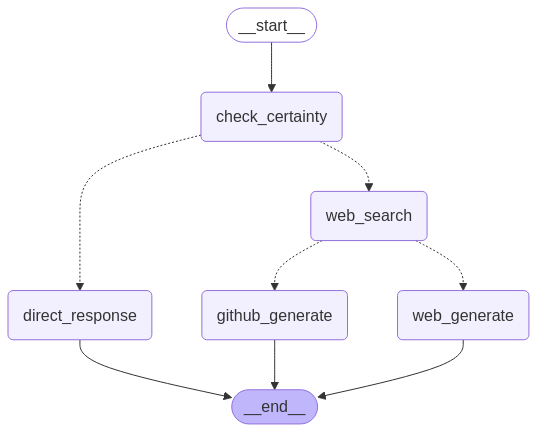

In [13]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [14]:
import pprint

inputs = {
    "question": "Yolo v5를 실행하는 방법에 대해서 알아? 정확한 코드를 줄래?"
}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

---CHECKING LLM'S CERTAINTY
---LLM IS NOT CERTAIN SO IT WILL DO WEB SEARCH
"Output from node 'check_certainty':"
'---'
{'certainty_score': 90}
'\n---\n'
---CHECK WHETHER WEB SEARCH IS SUFFICIENT FOR USER'S ASK
---DECISION: 웹 검색 결과로 해결 가능합니다.
"Output from node 'web_search':"
'---'
{ 'search_results': [ { 'content': 'YOLO v5 실습해보기\n'
                                   '\n'
                                   '인공지능 기초\n'
                                   '\n'
                                   'YOLOv5\n'
                                   '\n'
                                   '오늘은 YOLO v5 모델에 대해서 공부해보겠습니다 두둥\n'
                                   '욜로~\n'
                                   '욜로는 딥러닝 기반으로 객체를 인식해주는 모델이랍니다\n'
                                   '\n'
                                   '실행 환경\n'
                                   '\n'
                                   'Colab 환경에서 실행해주겠습니다.\n'
                                   '\n'
                                   '\n'
     

In [15]:
print("""'YOLO v5를 실행하는 방법에 대해 설명드리겠습니다. YOLO v5는 객체 탐지 모델로, PyTorch를 '
                '기반으로 하고 있습니다. 아래는 YOLO v5를 로컬 PC에서 실행하는 방법에 대한 단계별 가이드와 코드 '
                '예시입니다.\n'
                '\n'
                '### 1. 환경 설정\n'
                '먼저, YOLO v5를 실행하기 위해 필요한 환경을 설정해야 합니다. Python 3.9 이상이 설치되어 '
                '있어야 하며, 필요한 패키지를 설치하기 위해 `requirements.txt` 파일을 사용할 수 있습니다.\n'
                '\n'
                '```bash\n'
                '# YOLO v5 저장소 클론\n'
                'git clone https://github.com/ultralytics/yolov5.git\n'
                'cd yolov5\n'
                '\n'
                '# 필요한 패키지 설치\n'
                'pip install -r requirements.txt\n'
                '```\n'
                '\n'
                '### 2. 데이터 준비\n'
                'YOLO v5를 사용하기 위해서는 데이터셋이 필요합니다. 데이터셋은 이미지와 해당 이미지에 대한 레이블이 '
                '포함되어야 합니다. 레이블링 작업은 `labelImg`와 같은 도구를 사용하여 수행할 수 있습니다.\n'
                '\n'
                '### 3. YAML 파일 생성\n'
                '데이터셋을 준비한 후, YOLO v5가 데이터를 인식할 수 있도록 YAML 파일을 생성해야 합니다. 이 '
                '파일에는 데이터셋의 경로와 클래스 정보가 포함되어야 합니다. 예를 들어, `data.yaml` 파일은 다음과 '
                '같이 작성할 수 있습니다.\n'
                '\n'
                '```yaml\n'
                'train: ./custom_dataset/train/images\n'
                'val: ./custom_dataset/val/images\n'
                '\n'
                'nc: 2  # 클래스 수\n'
                "names: ['class1', 'class2']  # 클래스 이름\n"
                '```\n'
                '\n'
                '### 4. 모델 학습\n'
                '이제 YOLO v5 모델을 학습시킬 준비가 되었습니다. 아래의 코드를 사용하여 모델을 학습할 수 있습니다.\n'
                '\n'
                '```bash\n'
                '# 모델 학습\n'
                'python train.py --img 640 --batch 16 --epochs 50 --data '
                'data.yaml --weights yolov5s.pt\n'
                '```\n'
                '\n'
                '여기서 `--img`는 이미지 크기, `--batch`는 배치 크기, `--epochs`는 학습할 에폭 수, '
                '`--data`는 YAML 파일의 경로, `--weights`는 사용할 사전 학습된 모델의 경로를 '
                '지정합니다.\n'
                '\n'
                '### 5. 모델 추론\n'
                '학습이 완료된 후, 모델을 사용하여 이미지를 추론할 수 있습니다. 아래의 코드를 사용하여 이미지를 추론할 수 '
                '있습니다.\n'
                '\n'
                '```bash\n'
                '# 추론\n'
                'python detect.py --weights runs/train/exp/weights/best.pt '
                '--img 640 --conf 0.25 --source path/to/your/image.jpg\n'
                '```\n'
                '\n'
                '여기서 `--source`는 추론할 이미지의 경로를 지정합니다.\n'
                '\n'
                '### 결론\n'
                '위의 단계들을 통해 YOLO v5를 로컬 환경에서 실행하고, 객체 탐지 모델을 학습 및 추론할 수 있습니다. '
                '각 단계에서 필요한 파일과 경로를 정확히 설정하는 것이 중요합니다. 추가적인 세부사항이나 문제가 발생할 경우, '
                'YOLO v5의 공식 문서나 GitHub 페이지를 참조하는 것이 좋습니다.'""")

'YOLO v5를 실행하는 방법에 대해 설명드리겠습니다. YOLO v5는 객체 탐지 모델로, PyTorch를 '
                '기반으로 하고 있습니다. 아래는 YOLO v5를 로컬 PC에서 실행하는 방법에 대한 단계별 가이드와 코드 '
                '예시입니다.
'
                '
'
                '### 1. 환경 설정
'
                '먼저, YOLO v5를 실행하기 위해 필요한 환경을 설정해야 합니다. Python 3.9 이상이 설치되어 '
                '있어야 하며, 필요한 패키지를 설치하기 위해 `requirements.txt` 파일을 사용할 수 있습니다.
'
                '
'
                '```bash
'
                '# YOLO v5 저장소 클론
'
                'git clone https://github.com/ultralytics/yolov5.git
'
                'cd yolov5
'
                '
'
                '# 필요한 패키지 설치
'
                'pip install -r requirements.txt
'
                '```
'
                '
'
                '### 2. 데이터 준비
'
                'YOLO v5를 사용하기 위해서는 데이터셋이 필요합니다. 데이터셋은 이미지와 해당 이미지에 대한 레이블이 '
                '포함되어야 합니다. 레이블링 작업은 `labelImg`와 같은 도구를 사용하여 수행할 수 있습니다.
'
                '
'
                '### 3. YAML 파일 생성
'
                '데이터셋을 준비한 후, YOLO v5가 데이터를 인식할 수 있도